<a href="https://colab.research.google.com/github/Run-aivle/study/blob/main/March/03.27/SEN/SequenceModels(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 불러오기

In [14]:
pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model

In [16]:
# 삼성전자 종목
data = fdr.DataReader('005930', '2020-01-06', '2023-03-24')
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
2020-01-09,58400,58600,57400,58600,24102579,0.031690
2020-01-10,58800,59700,58300,59500,16000170,0.015358


In [17]:
data.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-03-20,61100,61200,60200,60200,9618009,-0.017945
2023-03-21,60500,60700,60100,60300,8318514,0.001661
2023-03-22,61000,61200,60500,61100,8978591,0.013267
2023-03-23,60600,62300,60600,62300,15381057,0.019640
2023-03-24,62700,63300,62300,63000,18278602,0.011236


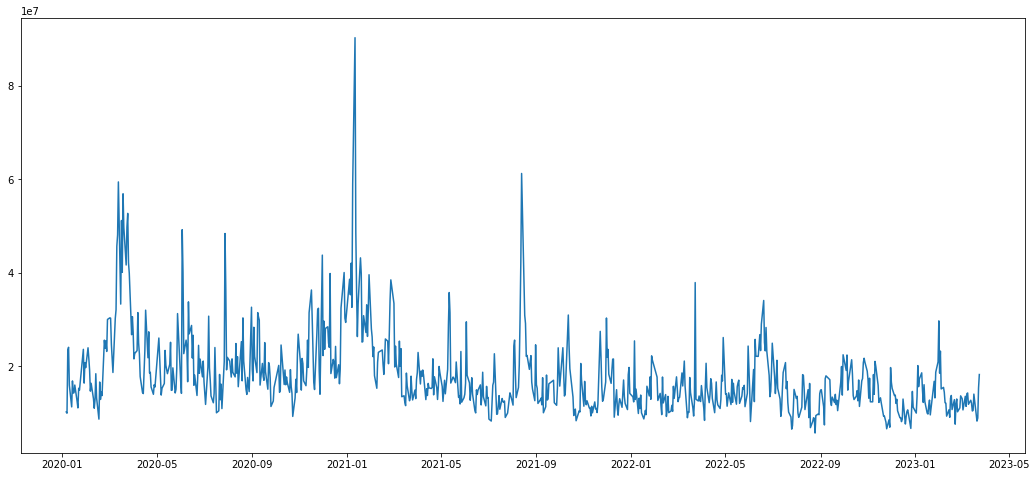

In [18]:
plt.figure(figsize = (18,8))
plt.plot(data['Volume'])
plt.show()

# 2. 데이터 준비

In [19]:
data.reset_index(inplace=True)

In [20]:
# 간단한 데이터로 변형
# 불필요한 컬럼 제거
data = data.drop(['Date'], axis = 1)
data.head()

,Open,High,Low,Close,Volume,Change
0,54900,55600,54600,55500,10278951,0.000000
1,55700,56400,55600,55800,10009778,0.005405
2,56200,57400,55900,56800,23501171,0.017921
3,58400,58600,57400,58600,24102579,0.031690
4,58800,59700,58300,59500,16000170,0.015358


In [21]:
data = data.values

In [22]:
data.shape

(797, 6)

In [23]:
# 주식 데이터는 1주가 5일
# 2주 데이터
timestep = 10
x = np.array([data[i : i+timestep, : ] for i in range(len(data) - timestep)])
y = np.array([data[i+timestep, -3] for i in range(len(data) - timestep)])

# test 데이터는 마지막 1주
# val 데이터는 test를 제외한 마지막 1주
x_train, x_val, x_test = x[:-15], x[-15:-5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15:-5], y[-5:]

print(x.shape, y.shape)
print('---------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(787, 10, 6) (787,)
---------------------
(772, 10, 6) (772,)
(10, 10, 6) (10,)
(5, 10, 6) (5,)


# 3. Sequence 데이터 구조로 만들기

In [26]:
# 1. 세션클리어
keras.backend.clear_session()

# 2. model 발판 생성
model = keras.models.Sequential()

# 3. model 블록 조립
model.add(keras.layers.Input(shape = (10, 6)))
model.add(keras.layers.SimpleRNN(16, activation = 'tanh', return_sequences=True))
model.add(keras.layers.SimpleRNN(32, activation = 'tanh', return_sequences=True))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,))

# 4. model compile
model.compile(loss = 'mae',
              optimizer = 'adam')

# 5. model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 16)            368       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 1)                 321       
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(x_train, y_train,
          epochs = 30, validation_data = [x_val, y_val])

Epoch 1/30
25/25 [==============================] - 2s 21ms/step - loss: 66593.6484 - val_loss: 60202.2383
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 66585.8984 - val_loss: 60193.3828
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 66576.2422 - val_loss: 60183.2422
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 66566.2109 - val_loss: 60173.4492
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 66556.5938 - val_loss: 60164.0078
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 66547.2734 - val_loss: 60154.8203
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 66538.1797 - val_loss: 60145.8047
Epoch 8/30
25/25 [==============================] - 0s 8ms/step - loss: 66529.2109 - val_loss: 60136.9062
Epoch 9/30
25/25 [==============================] - 0s 8ms/step - loss: 66520.3594 - val_loss: 60128.1133
Epoch 10/30
25/25 [==========================

In [29]:
y_pred = model.predict(x_test)

mean_squared_error(y_test, y_pred)**(0.5)

1/1 [==============================] - 0s 37ms/step


61133.253122449234